<h1 style="text-align: center;">Breaking RSA: An Implementation of Shor's Algorithm in Quantum Cryptography</h1>
<br>
<p style="text-align: center;"><strong>Prepared for:</strong> Dr. Sultan Almuhammadi</p>
<p style="text-align: center;"><strong>Prepared by:</strong> Ahmed Almalki</p>
<hr>

## Abstract:
This project explores the practical application of Shor's algorithm in breaking RSA encryption through quantum computing. My objective is to implement Shor's algorithm using Qiskit, an open-source quantum computing software development framework, to demonstrate the vulnerability of public-key cryptographic systems to quantum attacks. To date, I have developed a quantum circuit that successfully factors integers using simulated quantum processors. The implementation has been tested on small integers to validate the algorithm's functionality. Preliminary time complexity analysis suggests scalability to more significant integers with an increase in qubit resources. My ongoing work aims to refine the algorithm's efficiency and prepare for a demonstration on an actual quantum processor.

In [144]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_city, plot_state_hinton

from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from fractions import Fraction


In [145]:
def run_on_simulation(qc, shots=100):
#     simulator = Aer.get_backend('qasm_simulator')
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qc, simulator, shots=shots)

    return job.result()

def least_busy_backend(n_qubits):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n_qubits+1) and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    
    return backend


def run_on_IBMQ(qc, backend, shots=100):
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    job_monitor(job, interval=2)
    
    return job.result()


In [186]:
def c_amodN(a, N, power, draw=False):
#     if N==15:
#         return _c_amod15(a, power)
        
    ns=[]
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    
    for n in range(2,N):
        if math.gcd(n,N)==1:
            ns.append(n)
    print(f"## {power} ##")
    if(draw):
        return _c_amodN_print(a, N, ns, n_len, m_len, power)
    
    if a not in ns:
        raise ValueError(f"'a' must be {ns}")
    U = QuantumCircuit(n_len)
    
    for i, bit in enumerate(format(a**power%N, f'0{n_len}b')):
        if bit == '1':
            U.x(i)

    U = U.to_gate()
    U.name = f"{a}^{power} mod {N}"
    c_U = U.control()
         
    return c_U


def _c_amodN_print(a, N, ns, n_len, m_len, power):        
    print(ns)
    
    U = QuantumCircuit(n_len)
    print(f"a(int) = {a}")
    print(f"a(bin) = {format(a, f'0{n_len}b')}")
    print(f"p(int) = {power}")
    print(f"{a}^{p}%{N} (int) = {a**power%N}")
    print(f"{a}^{p}%{N} (bin) = {format(a**power%N, f'0{n_len}b')}")
    print(f"x_gates = {format(pow(a,power,N)^1, f'0{n_len}b')}")
    print(f"x_gates = {format(pow(a,power,N)^1, f'0{n_len}b')}")
    
    for i, bit in enumerate(format(a**power%N, f'0{n_len}b')):
        if bit == '1':
            U.x(i)
    U.barrier()
    for i, bit in enumerate(format((a**power%N)^1, f'0{n_len}b')):
        if bit == '1':
            U.x(i)
    display(U.draw('mpl'))

    return U


# def _c_amod15(a, power):
#     """Controlled multiplication by a mod 15"""
#     if a not in [2,4,7,8,11,13]:
#         raise ValueError("'a' must be 2,4,7,8,11 or 13")
#     U = QuantumCircuit(4)
#     for _iteration in range(1):
#         if a in [2]:
#             U.x(2)
#             U.x(3)
#         if a in [13]:
#             U.swap(2,3)
#             U.swap(1,2)
#             U.swap(0,1)
#         if a in [7]:
#             U.x(1)
#             U.x(2)
#         if a in [8]:
#             U.swap(0,1)
#             U.swap(1,2)
#             U.swap(2,3)
#         if a in [4]:
#             U.swap(1,3)
#             U.swap(0,2)
#         if a in [11]:
#             U.swap(1,3)
#             U.swap(0,2)
# #         if a in [7,11,13]:
# #             for q in range(4):
# #                 U.x(q)
#     display(U.draw('mpl'))
#     U = U.to_gate()
#     U.name = f"{a}^{power} mod 15"
#     c_U = U.control()
#     return c_U

In [187]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [188]:
N=15
a=7
n_len = math.ceil(math.log2(N))
m_len = 2*n_len

## 2 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 2
2^1%15 (int) = 4
2^1%15 (bin) = 0100
x_gates = 0101
x_gates = 0101


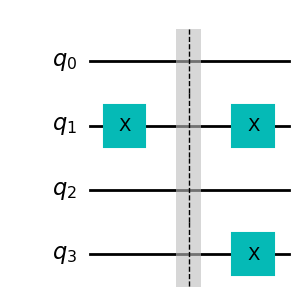

## 4 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 4
2^2%15 (int) = 1
2^2%15 (bin) = 0001
x_gates = 0000
x_gates = 0000


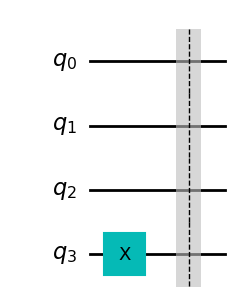

## 8 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 8
2^3%15 (int) = 1
2^3%15 (bin) = 0001
x_gates = 0000
x_gates = 0000


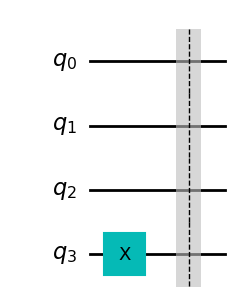

## 16 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 16
2^4%15 (int) = 1
2^4%15 (bin) = 0001
x_gates = 0000
x_gates = 0000


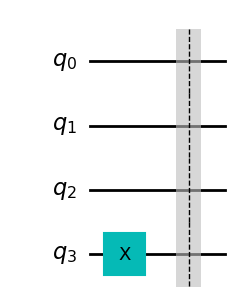

## 32 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 32
2^5%15 (int) = 1
2^5%15 (bin) = 0001
x_gates = 0000
x_gates = 0000


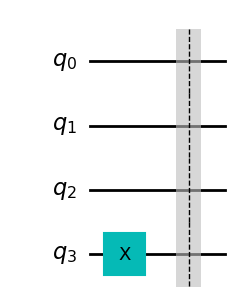

## 64 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 64
2^6%15 (int) = 1
2^6%15 (bin) = 0001
x_gates = 0000
x_gates = 0000


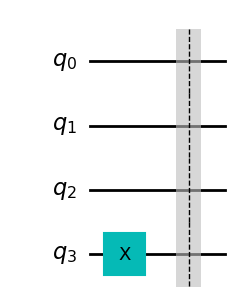

## 128 ##
[2, 4, 7, 8, 11, 13, 14]
a(int) = 2
a(bin) = 0010
p(int) = 128
2^7%15 (int) = 1
2^7%15 (bin) = 0001
x_gates = 0000
x_gates = 0000


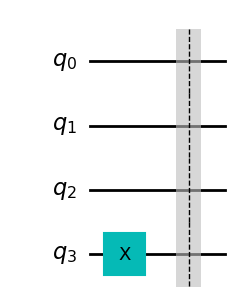

In [189]:
for p in range(1,m_len):
    c_amodN(2,15,2**p,draw=True)

In [112]:
# from qiskit.circuit.library import QFT

## 1 ##
## 2 ##
## 4 ##
## 8 ##
## 16 ##
## 32 ##
## 64 ##
## 128 ##


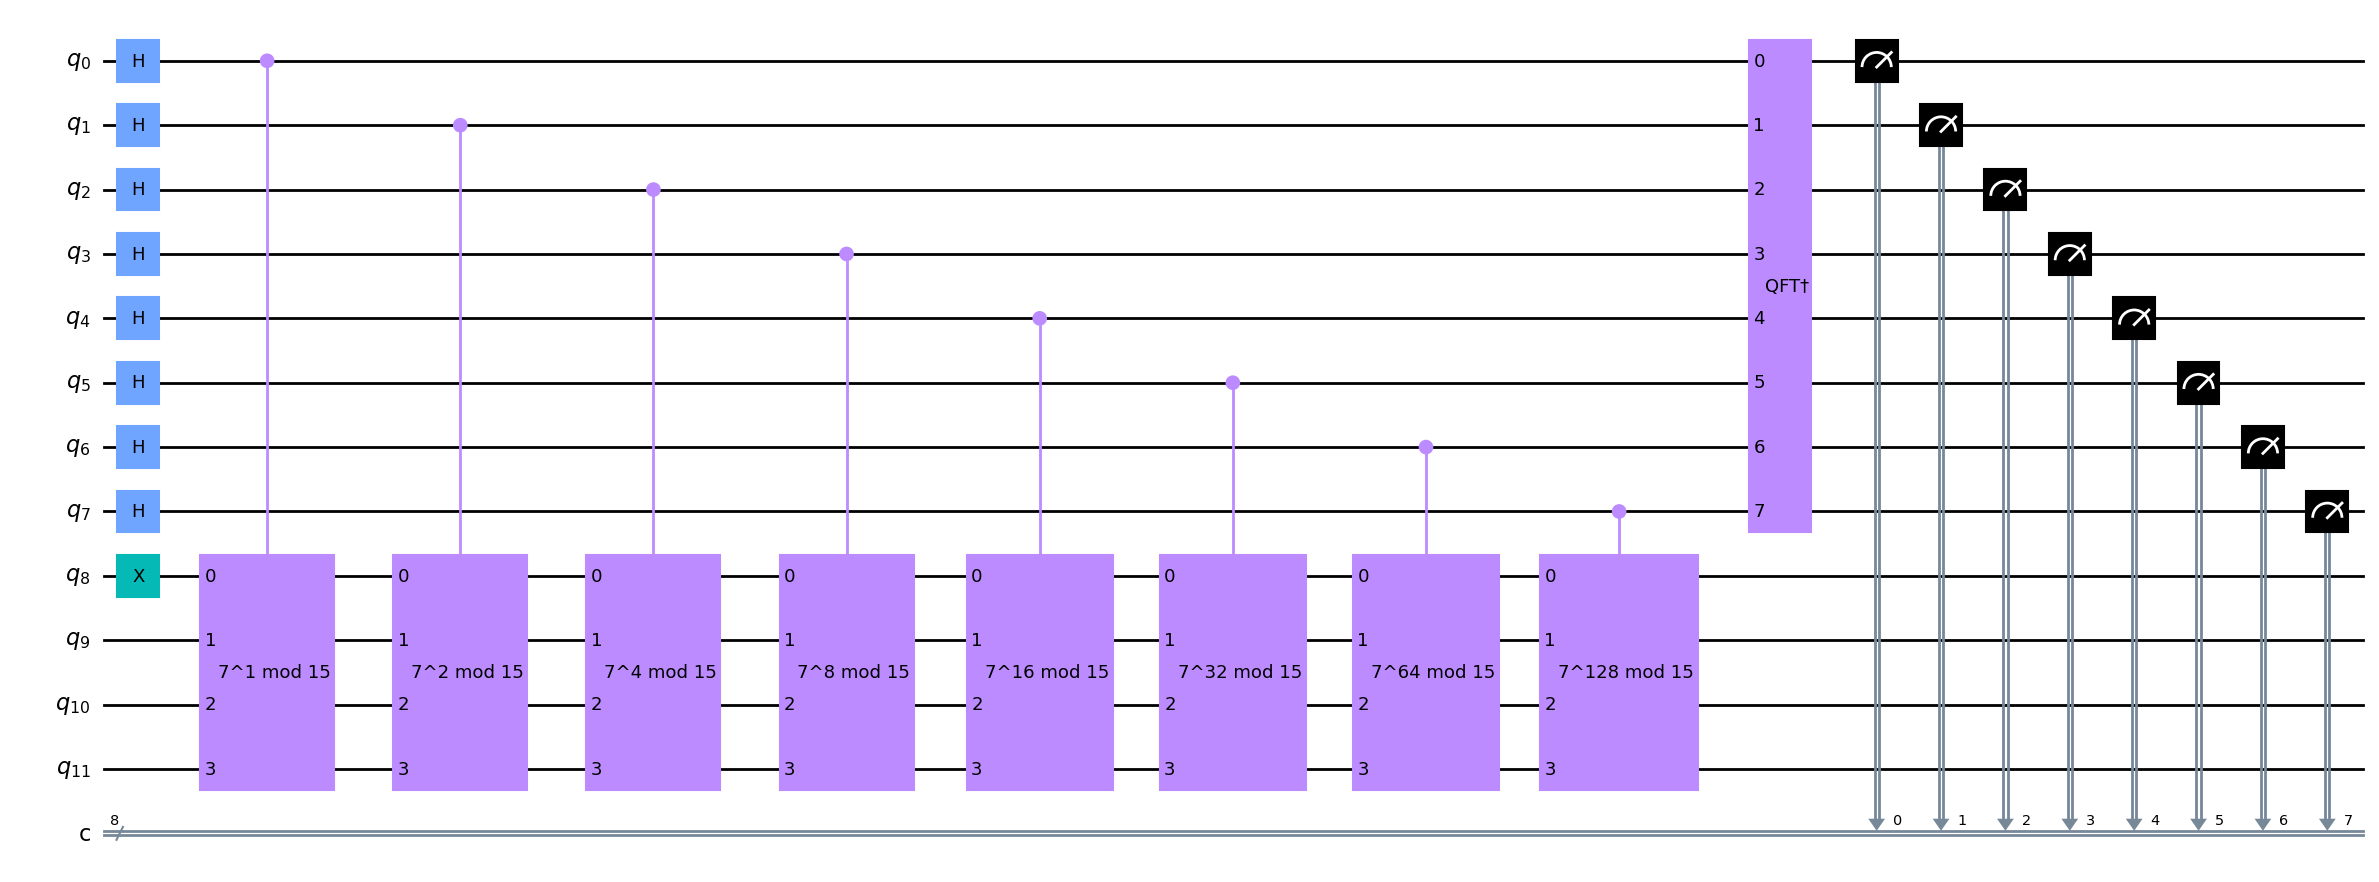

In [175]:
qc = QuantumCircuit(m_len + n_len, m_len)

# Initialize counting qubits
# in state |+>
for q in range(m_len):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(m_len)

# Do controlled-U operations
for q in range(m_len):
    qc.append(c_amodN(a, N, 2**q),
             [q] + [i+m_len for i in range(n_len)])

# Do inverse-QFT
qc.append(qft_dagger(m_len), range(m_len))
# qc.append(QFT(m_len, inverse=True), range(m_len))
# qc.append(QFT(m_len).inverse(), range(m_len))


# Measure circuit
qc.measure(range(m_len), range(m_len))
qc.draw(fold=-1, output='mpl', style='clifford')  # -1 means 'do not fold'

In [114]:
# counts = run_on_simulation(qc).get_counts()
# plot_histogram(counts, figsize=(17, 5))

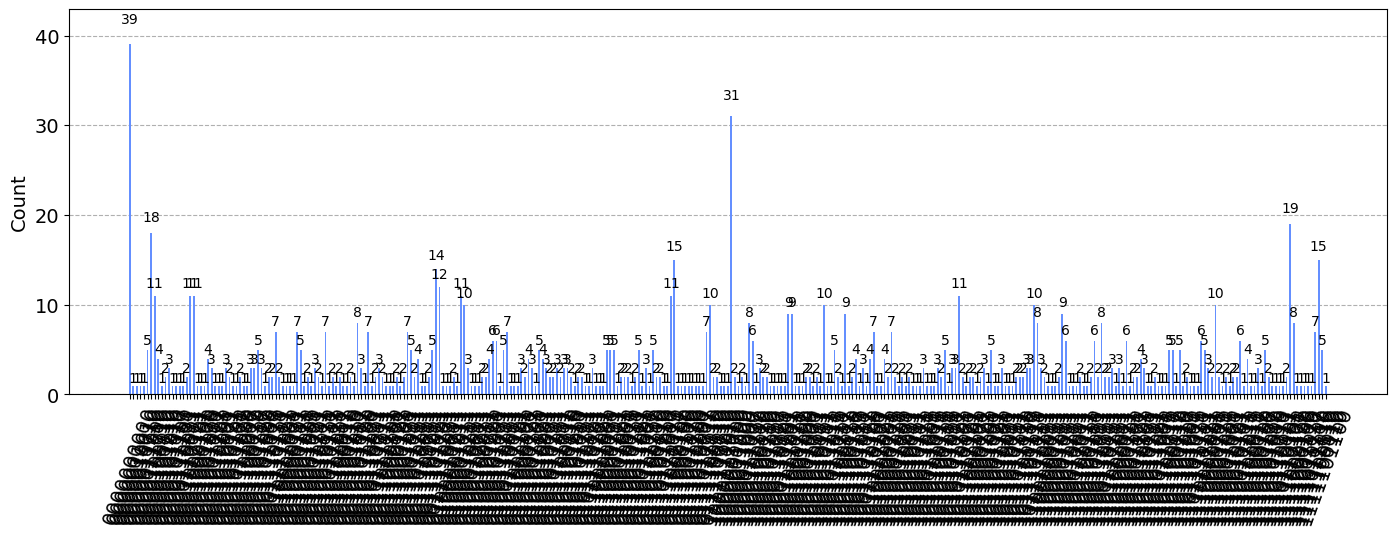

Outliers: {'1000000000': 31, '0000000000': 39, '1110111100': 19, '0111000100': 15, '0000011110': 18, '1111100010': 15}


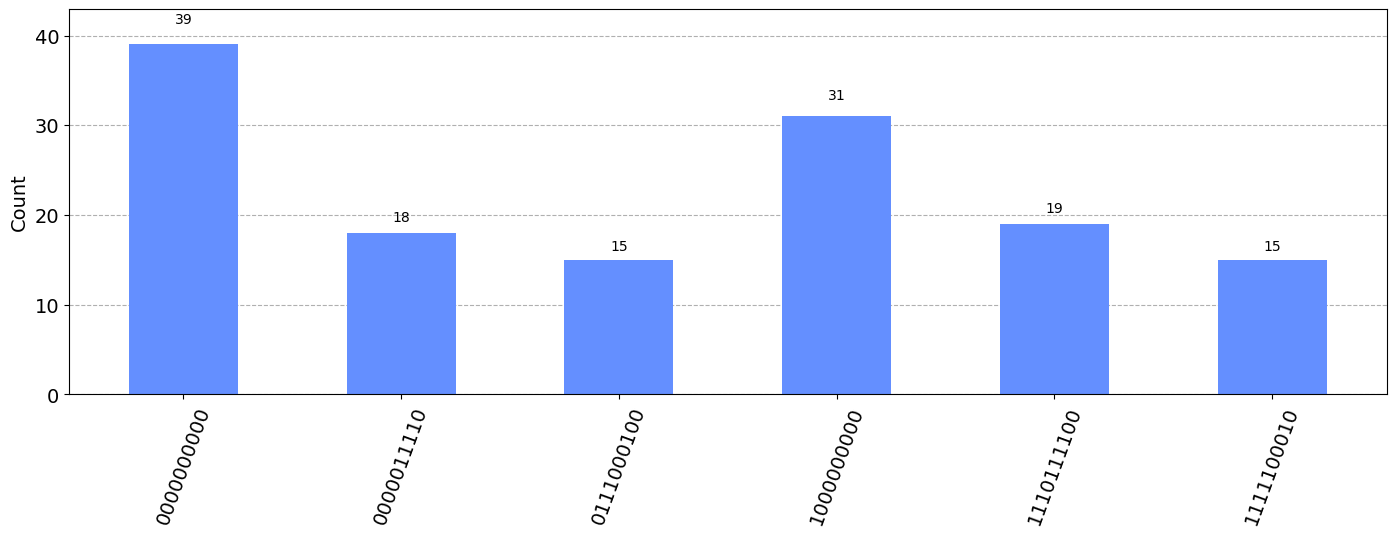

In [122]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
display(plot_histogram(counts, figsize=(17, 5)))


values = list(counts.values())
mean = np.mean(values)
std_dev = np.std(values)

# Define a threshold for outliers
threshold = 3 * std_dev

# Identify outliers
counts = {key: val for key, val in counts.items() if abs(val - mean) > threshold}

# Print outliers
print("Outliers:", counts)

# Plot histogram
plot_histogram(counts, figsize=(17, 5))


In [124]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**m_len)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**m_len} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

              Register Output            Phase
0  1000000000(bin) = 512(dec)  512/1024 = 0.50
1  0000000000(bin) =   0(dec)    0/1024 = 0.00
2  1110111100(bin) = 956(dec)  956/1024 = 0.93
3  0111000100(bin) = 452(dec)  452/1024 = 0.44
4  0000011110(bin) =  30(dec)   30/1024 = 0.03
5  1111100010(bin) = 994(dec)  994/1024 = 0.97


In [125]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0  0.500000      1/2            2
1  0.000000      0/1            1
2  0.933594    14/15           15
3  0.441406    11/25           25
4  0.029297     1/25           25
5  0.970703    24/25           25


In [126]:
# df['Guess for r'].value_counts()

In [127]:
# df.groupby('Guess for r').sum('Phase').sort_values('Phase')

In [128]:
# df.groupby('Guess for r').max('Phase').sort_values('Phase')

In [129]:
math.gcd(a, N)

1

In [130]:
def qpe_amodN(a, N):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qc = QuantumCircuit(n_len+m_len, m_len)
    for q in range(m_len):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(m_len) # And auxiliary register in state |1>
    for q in range(m_len): # Do controlled-U operations
        qc.append(c_amodN(a, N, 2**q),
                 [q] + [i+m_len for i in range(n_len)])
    qc.append(qft_dagger(m_len), range(m_len)) # Do inverse-QFT
    qc.measure(range(m_len), range(m_len))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**m_len)
    print(f"Corresponding Phase: {phase}")
    return phase

In [131]:
phase = qpe_amodN(a, N) # Phase = s/r
Fraction(phase).limit_denominator(N)

Register Reading: 1101010111
Corresponding Phase: 0.8349609375


Fraction(5, 6)

In [132]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

6


In [133]:
guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
print(guesses)

[1, 5]


In [143]:
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amodN(a, N) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0 and check_r_condition(a, r, N):
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 1000011110
Corresponding Phase: 0.529296875
Result: r = 17

ATTEMPT 2:
Register Reading: 0011110001
Corresponding Phase: 0.2353515625
Result: r = 17

ATTEMPT 3:
Register Reading: 1011101101
Corresponding Phase: 0.7314453125
Result: r = 15

ATTEMPT 4:
Register Reading: 1010010111
Corresponding Phase: 0.6474609375
Result: r = 17

ATTEMPT 5:
Register Reading: 0001101000
Corresponding Phase: 0.1015625
Result: r = 10

ATTEMPT 6:
Register Reading: 1000100010
Corresponding Phase: 0.533203125
Result: r = 15

ATTEMPT 7:
Register Reading: 1001111000
Corresponding Phase: 0.6171875
Result: r = 13

ATTEMPT 8:
Register Reading: 0110001000
Corresponding Phase: 0.3828125
Result: r = 13

ATTEMPT 9:
Register Reading: 0110100110
Corresponding Phase: 0.412109375
Result: r = 17

ATTEMPT 10:
Register Reading: 0011010001
Corresponding Phase: 0.2041015625
Result: r = 5

ATTEMPT 11:
Register Reading: 1000100010
Corresponding Phase: 0.533203125
Result: r = 15

ATTEMPT 12:
Register 

In [45]:
def check_r_condition(a, r, N):
    if r % 2 == 0 and pow(a, r // 2, N) != N - 1:
        return True
    else:
        return False